### Cell 0 – Build long-format Fall 2025 dataset (`parking_q1`)

This cell:
- Reads all `Parking_Occupancy_Fall_2025_Week*.csv` files (Weeks 0–2, Fall 2025).
- Parses the date from the header and derives `day_of_week` and `week_label`.
- Reshapes the wide time columns (8, 10, 12, 2) into **long format**, so each row is one observation at a specific `date × location × space_type × lot_type × time_of_day`.
- Stores the result in a pandas DataFrame called `parking_q1` and saves it as `parking_q1_fall2025_long.csv` for reuse.


In [1]:
import csv
import re
import datetime as dt
from pathlib import Path

import pandas as pd

# Collect all raw Fall 2025 occupancy CSVs (Weeks 0–2)
raw_files = sorted(Path('.').glob('Parking_Occupancy_Fall_2025_Week*.csv'))

records = []

for path in raw_files:
    with path.open(encoding='utf-8', newline='') as f:
        lines = f.readlines()

    if len(lines) < 4:
        continue

    # Line 2 contains the date and the phrase "Available Spaces".
    # Example: "Monday, September 29, 2025",,,Available Spaces,,,
    m = re.search(r"[A-Za-z]+, [A-Za-z]+ \d{1,2}, \d{4}", lines[1])
    if not m:
        # If we cannot parse the date, skip this file
        continue

    date_str = m.group(0)
    try:
        date_obj = dt.datetime.strptime(date_str, "%A, %B %d, %Y").date()
    except ValueError:
        # Fallback: drop weekday if needed
        try:
            date_obj = dt.datetime.strptime(date_str.split(', ', 1)[1], "%B %d, %Y").date()
        except Exception:
            continue

    day_of_week = date_obj.strftime('%A')

    # Derive a simple week label from the filename, e.g. "Week1"
    m_week = re.search(r"Week(\d+)", path.name)
    week_label = f"Week{m_week.group(1)}" if m_week else "Unknown"

    # Header row is line 3 (0‑based index 2)
    header = next(csv.reader([lines[2]]))
    # Expect: ['Space Type', '', 'Location', '8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
    time_cols = header[3:]

    # Data starts at line 4 (index 3)
    for data_line in lines[3:]:
        if not data_line.strip():
            continue

        row = next(csv.reader([data_line]))
        # Pad to length of header if needed
        if len(row) < len(header):
            row += [''] * (len(header) - len(row))

        space_type = row[0].strip()
        lot_type = row[1].strip()
        location = row[2].strip()

        # Skip rows without a location
        if not location:
            continue

        for idx, t in enumerate(time_cols, start=3):
            val = row[idx].strip() if idx < len(row) else ''
            if val == '':
                continue
            try:
                available = int(val)
            except ValueError:
                continue

            records.append(
                {
                    'date': date_obj.isoformat(),
                    'day_of_week': day_of_week,
                    'week_label': week_label,
                    'source_file': path.name,
                    'space_type': space_type,
                    'lot_type': lot_type,
                    'location': location,
                    'time_of_day': t.strip(),
                    'available_spaces': available,
                }
            )

# Build the long-format DataFrame for Q1
parking_q1 = pd.DataFrame.from_records(records)

# Save a canonical CSV for future analyses
output_path = Path('parking_q1_fall2025_long.csv')
parking_q1.to_csv(output_path, index=False)

print(f"Created {output_path} with shape {parking_q1.shape}")
parking_q1.head()


Created parking_q1_fall2025_long.csv with shape (4284, 9)


,date,day_of_week,week_label,source_file,space_type,lot_type,location,time_of_day,available_spaces
0,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,8:00 AM,23
1,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,10:00 AM,18
2,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,12:00 PM,21
3,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,2:00 PM,18
4,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,,Athena,8:00 AM,177


### Cell 1 – Filter to parking structures and basic summary

This cell:
- Reloads the canonical CSV `parking_q1_fall2025_long.csv` into `parking_q1`.
- Creates `parking_structures` by keeping only rows where `lot_type` contains the word "Structure".
- Prints the unique `lot_type` values and the shape of this structures-only subset.
- Computes a quick summary of `available_spaces` grouped by `space_type` and `time_of_day`, to see how many observations and what the typical availability looks like in structures.


In [2]:
import pandas as pd
from pathlib import Path

# Load the canonical long-format CSV (re-loads safely even if the first cell
# hasn't been run in this session)
csv_path = Path('parking_q1_fall2025_long.csv')
if not csv_path.exists():
    raise FileNotFoundError(
        f"{csv_path} not found. Run the first cell to generate it before running this one."
    )

parking_q1 = pd.read_csv(csv_path)

# Filter to parking structures only (exclude surface lots etc.)
mask_struct = parking_q1['lot_type'].astype(str).str.contains('Structure', case=False, na=False)
parking_structures = parking_q1[mask_struct].copy()

print("Unique lot_type values in structures subset:")
print(parking_structures['lot_type'].value_counts())

print("\nBasic shape (rows, columns) of structures-only data:")
print(parking_structures.shape)

# Quick summary of availability by permit type and time of day
summary_by_space_time = (
    parking_structures
    .groupby(['space_type', 'time_of_day'])['available_spaces']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['space_type', 'time_of_day'])
)

print("\nSummary of available spaces by space_type and time_of_day (structures only):")
print(summary_by_space_time.head(20))

parking_structures.head()


Unique lot_type values in structures subset:
lot_type
Structure    200
Name: count, dtype: int64

Basic shape (rows, columns) of structures-only data:
(200, 9)

Summary of available spaces by space_type and time_of_day (structures only):
   space_type time_of_day  count       mean        std
0           A    10:00 AM     10  21.100000   8.621034
1           A    12:00 PM     10  19.500000   4.672615
2           A     2:00 PM      9  19.000000   5.722762
3           A     8:00 AM     10  25.400000   8.167687
4           A           `      1  19.000000        NaN
5           B    10:00 AM     10  14.000000   8.730534
6           B    12:00 PM     10  11.000000   8.137704
7           B     2:00 PM      9  12.555556   7.299163
8           B     8:00 AM     10  19.600000   8.834277
9           B           `      1   5.000000        NaN
10          S    10:00 AM     10  53.100000  11.798776
11          S    12:00 PM     10  45.500000   7.947746
12          S     2:00 PM      9  46.777778   6

,date,day_of_week,week_label,source_file,space_type,lot_type,location,time_of_day,available_spaces
0,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,8:00 AM,23
1,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,10:00 AM,18
2,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,12:00 PM,21
3,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,2:00 PM,18
92,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,B,Structure,8980,8:00 AM,16


### Cell 2 – Light EDA for structures (overall and A vs B)

This cell:
- Makes sure `time_of_day` is ordered as 8:00, 10:00, 12:00, and 2:00.
- **Overall EDA**: Groups `parking_structures` by `time_of_day` to compute and print the `count`, `mean`, and `std` of `available_spaces`, and plots mean availability vs time of day for all permits combined.
- **A vs B EDA**: Filters to `space_type` A and B, groups by `space_type × time_of_day`, prints the summary table, and plots two lines (A vs B) so you can visually compare how staff vs student permits differ in availability across the day in structures.


Overall availability by time_of_day (structures only):
  time_of_day  count       mean        std
0     8:00 AM     50  45.340000  76.578787
1    10:00 AM     50  27.380000  20.568343
2    12:00 PM     50  22.140000  17.123811
3     2:00 PM     45  22.333333  17.332313


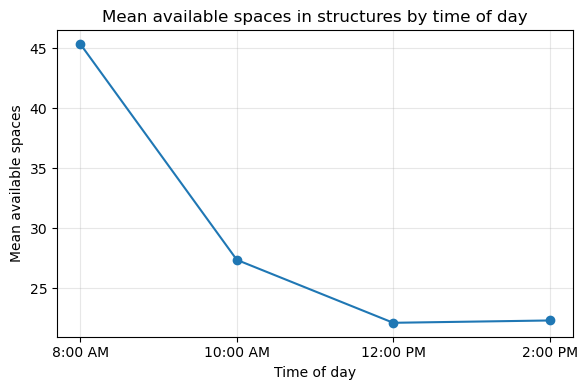


Availability by space_type (A/B) and time_of_day (structures only):
  space_type time_of_day  count       mean       std
0          A     8:00 AM     10  25.400000  8.167687
1          A    10:00 AM     10  21.100000  8.621034
2          A    12:00 PM     10  19.500000  4.672615
3          A     2:00 PM      9  19.000000  5.722762
4          B     8:00 AM     10  19.600000  8.834277
5          B    10:00 AM     10  14.000000  8.730534
6          B    12:00 PM     10  11.000000  8.137704
7          B     2:00 PM      9  12.555556  7.299163


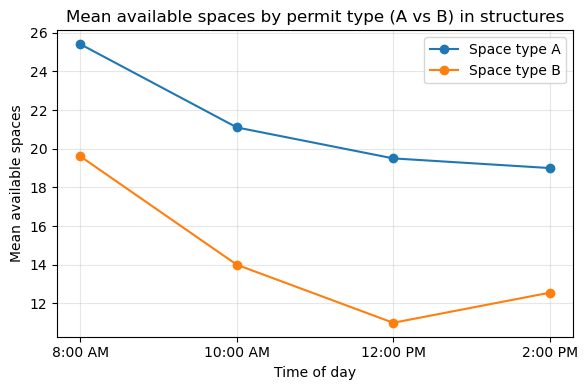

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# This cell assumes you've already run the previous cell so that
# `parking_structures` exists (structures-only, long format)

if 'parking_structures' not in globals():
    raise NameError("Run the previous cell first to create `parking_structures`.")

# Ensure a sensible ordering of times
time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
parking_structures = parking_structures.copy()
parking_structures['time_of_day'] = pd.Categorical(
    parking_structures['time_of_day'], categories=time_order, ordered=True
)

# --- EDA 1: Overall availability by time of day (all permits, structures only) ---
summary_time = (
    parking_structures
    .groupby('time_of_day', observed=True)['available_spaces']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values('time_of_day')
)

print("Overall availability by time_of_day (structures only):")
print(summary_time)

plt.figure(figsize=(6, 4))
plt.plot(summary_time['time_of_day'], summary_time['mean'], marker='o')
plt.xlabel('Time of day')
plt.ylabel('Mean available spaces')
plt.title('Mean available spaces in structures by time of day')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- EDA 2: Focus on A vs B permits by time of day (structures only) ---
mask_ab = parking_structures['space_type'].isin(['A', 'B'])
ab_structures = parking_structures[mask_ab].copy()

summary_ab_time = (
    ab_structures
    .groupby(['space_type', 'time_of_day'], observed=True)['available_spaces']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['space_type', 'time_of_day'])
)

print("\nAvailability by space_type (A/B) and time_of_day (structures only):")
print(summary_ab_time)

plt.figure(figsize=(6, 4))
for stype, grp in summary_ab_time.groupby('space_type'):
    plt.plot(grp['time_of_day'], grp['mean'], marker='o', label=f'Space type {stype}')

plt.xlabel('Time of day')
plt.ylabel('Mean available spaces')
plt.title('Mean available spaces by permit type (A vs B) in structures')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Cell 3 – Light EDA for NON-structures (surface lots, etc.)

This cell:
- Creates `parking_non_structures` by selecting rows where `lot_type` does **not** contain the word "Structure" (i.e., surface lots and other non-structure facilities).
- Prints the unique `lot_type` values and the shape of this non-structure subset.
- **Overall EDA**: Groups by `time_of_day` to summarize and plot mean `available_spaces` vs time of day for all permits combined in non-structures.
- **A vs B EDA**: Filters to A and B permits only, groups by `space_type × time_of_day`, prints the table, and plots A vs B lines to compare how availability behaves in surface lots.


Unique lot_type values in NON-structures subset:
lot_type
Surface Lot    216
Name: count, dtype: int64

Basic shape (rows, columns) of non-structures data:
(4084, 9)

Overall availability by time_of_day (NON-structures):
  time_of_day  count       mean        std
0     8:00 AM   1021  59.142018  86.352415
1    10:00 AM   1021  40.531832  67.311001
2    12:00 PM   1021  27.741430  52.273955
3     2:00 PM    923  27.905742  49.344981


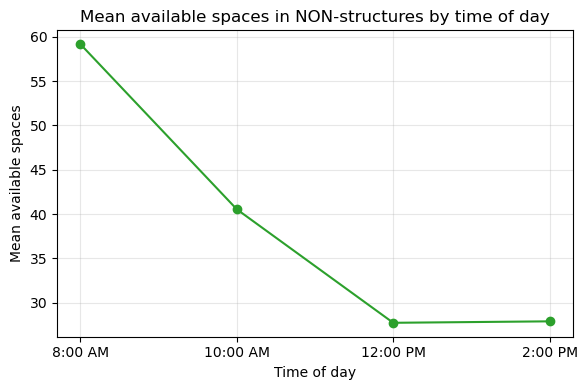


Availability by space_type (A/B) and time_of_day (NON-structures):
  space_type time_of_day  count       mean        std
0          A     8:00 AM    225  71.915556  98.730590
1          A    10:00 AM    225  50.017778  72.898104
2          A    12:00 PM    225  34.528889  54.601399
3          A     2:00 PM    203  36.004926  55.905640
4          B     8:00 AM    370  50.778378  69.001116
5          B    10:00 AM    370  31.954054  56.607578
6          B    12:00 PM    370  19.472973  40.843751
7          B     2:00 PM    334  19.658683  37.625829


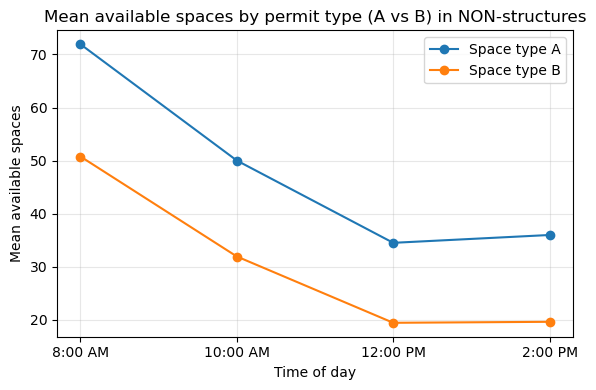

,date,day_of_week,week_label,source_file,space_type,lot_type,location,time_of_day,available_spaces
4,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,NaN,Athena,8:00 AM,177
5,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,NaN,Athena,10:00 AM,143
6,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,NaN,Athena,12:00 PM,101
7,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,NaN,Athena,2:00 PM,102
8,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,NaN,Campus Point East,8:00 AM,117


In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# EDA for NON-structure lots (e.g., surface lots)

# Ensure we have the full long-format data available
if 'parking_q1' not in globals():
    raise NameError("Run the first cell to create `parking_q1` before this one.")

parking_non_structures = parking_q1[~parking_q1['lot_type'].astype(str).str.contains('Structure', case=False, na=False)].copy()

print("Unique lot_type values in NON-structures subset:")
print(parking_non_structures['lot_type'].value_counts())

print("\nBasic shape (rows, columns) of non-structures data:")
print(parking_non_structures.shape)

# Order times consistently
time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
parking_non_structures['time_of_day'] = pd.Categorical(
    parking_non_structures['time_of_day'], categories=time_order, ordered=True
)

# --- EDA 1: Overall availability by time of day (all permits, NON-structures) ---
summary_time_non = (
    parking_non_structures
    .groupby('time_of_day', observed=True)['available_spaces']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values('time_of_day')
)

print("\nOverall availability by time_of_day (NON-structures):")
print(summary_time_non)

plt.figure(figsize=(6, 4))
plt.plot(summary_time_non['time_of_day'], summary_time_non['mean'], marker='o', color='tab:green')
plt.xlabel('Time of day')
plt.ylabel('Mean available spaces')
plt.title('Mean available spaces in NON-structures by time of day')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- EDA 2: A vs B permits by time of day (NON-structures) ---
mask_ab_non = parking_non_structures['space_type'].isin(['A', 'B'])
ab_non = parking_non_structures[mask_ab_non].copy()

summary_ab_time_non = (
    ab_non
    .groupby(['space_type', 'time_of_day'], observed=True)['available_spaces']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['space_type', 'time_of_day'])
)

print("\nAvailability by space_type (A/B) and time_of_day (NON-structures):")
print(summary_ab_time_non)

plt.figure(figsize=(6, 4))
for stype, grp in summary_ab_time_non.groupby('space_type'):
    plt.plot(grp['time_of_day'], grp['mean'], marker='o', label=f'Space type {stype}')

plt.xlabel('Time of day')
plt.ylabel('Mean available spaces')
plt.title('Mean available spaces by permit type (A vs B) in NON-structures')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

parking_non_structures.head()


### Cell 4 – All permit / space types on one plot (structures)

This cell:
- Uses `parking_structures` to group by `space_type × time_of_day`, computing `count`, `mean`, and `std` of `available_spaces` for each permit type at each time.
- Prints the full summary table so you can see how much data and how much variation you have for each combination.
- Plots a multi-line graph where each line corresponds to a `space_type` (A, B, S, SR, etc.) across 8:00, 10:00, 12:00, and 2:00, making it easy to visually compare differences in availability patterns across all permit types in structures.


Availability by space_type and time_of_day (all types, structures only):
   space_type time_of_day  count       mean         std
0           A     8:00 AM     10  25.400000    8.167687
1           A    10:00 AM     10  21.100000    8.621034
2           A    12:00 PM     10  19.500000    4.672615
3           A     2:00 PM      9  19.000000    5.722762
4           B     8:00 AM     10  19.600000    8.834277
5           B    10:00 AM     10  14.000000    8.730534
6           B    12:00 PM     10  11.000000    8.137704
7           B     2:00 PM      9  12.555556    7.299163
8           S     8:00 AM     10  61.700000   16.438775
9           S    10:00 AM     10  53.100000   11.798776
10          S    12:00 PM     10  45.500000    7.947746
11          S     2:00 PM      9  46.777778    6.300353
12         SR     8:00 AM     10  30.700000   31.864470
13         SR    10:00 AM     10  14.000000   25.905812
14         SR    12:00 PM     10   2.400000    3.893014
15         SR     2:00 PM      

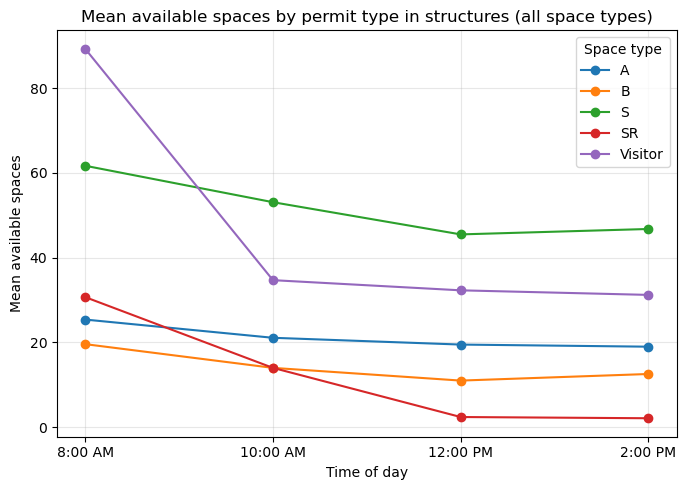

,space_type,time_of_day,count,mean,std
0,A,8:00 AM,10,25.4,8.167687
1,A,10:00 AM,10,21.1,8.621034
2,A,12:00 PM,10,19.5,4.672615
3,A,2:00 PM,9,19.0,5.722762
4,B,8:00 AM,10,19.6,8.834277


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Overall availability by permit / space_type in structures

if 'parking_structures' not in globals():
    raise NameError("Run the earlier cells to create `parking_structures` first.")

# Ensure consistent time ordering
time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
parking_structures = parking_structures.copy()
parking_structures['time_of_day'] = pd.Categorical(
    parking_structures['time_of_day'], categories=time_order, ordered=True
)

summary_all_types = (
    parking_structures
    .groupby(['space_type', 'time_of_day'], observed=True)['available_spaces']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['space_type', 'time_of_day'])
)

print("Availability by space_type and time_of_day (all types, structures only):")
print(summary_all_types)

plt.figure(figsize=(7, 5))
for stype, grp in summary_all_types.groupby('space_type'):
    plt.plot(grp['time_of_day'], grp['mean'], marker='o', label=f'{stype}')

plt.xlabel('Time of day')
plt.ylabel('Mean available spaces')
plt.title('Mean available spaces by permit type in structures (all space types)')
plt.legend(title='Space type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

summary_all_types.head()


### Cell 5 – First-pass formal test for Research Question 1 (A vs B at peak times)

This cell:
- Focuses on **structures only**, **A and B permits**, and **peak times (10:00 AM and 12:00 PM)** to match your Q1 framing about when parking is busiest.
- Builds `q1_data` by subsetting to those rows and prints a preview and structure-level mean `available_spaces`.
- Computes an overall summary (`count`, `mean`, `std`) of `available_spaces` for A vs B at peak times.
- Runs a **Welch two-sample t-test** (`stats.ttest_ind(vals_A, vals_B, equal_var=False)`):
  - **Null hypothesis**: Mean available spaces at peak times are the same for A and B permits in structures.
  - **Alternative**: The means differ.
  - Reports the t-statistic, p-value, and the difference in sample means (A − B), which tells you both **whether** and **by how much** A and B differ in average availability at peak times.


In [6]:
import pandas as pd
from scipy import stats

# Deeper Q1 step: focus on structures, A vs B, peak times, and compare means

if 'parking_structures' not in globals():
    raise NameError("Run the earlier cells to create `parking_structures` first.")

peak_times = ['10:00 AM', '12:00 PM']

q1_data = (
    parking_structures
    .loc[parking_structures['time_of_day'].isin(peak_times)]
    .copy()
)

# Keep only A and B permits
q1_data = q1_data[q1_data['space_type'].isin(['A', 'B'])].copy()

print("Q1 dataset (structures, A/B only, peak times) shape:", q1_data.shape)
print(q1_data[['date', 'location', 'space_type', 'time_of_day', 'available_spaces']].head())

# Structure-level mean availability at peak times
struct_means = (
    q1_data
    .groupby(['location', 'space_type'])['available_spaces']
    .mean()
    .reset_index(name='mean_available_spaces')
)

print("\nStructure-level mean available spaces at peak times (first 10 rows):")
print(struct_means.head(10))

# Overall mean and std by space_type
summary_q1 = (
    q1_data
    .groupby('space_type')['available_spaces']
    .agg(['count', 'mean', 'std'])
)

print("\nOverall summary by space_type (A vs B) at peak times:")
print(summary_q1)

# Two-sample t-test (Welch) comparing A vs B available spaces at peak times
vals_A = q1_data.loc[q1_data['space_type'] == 'A', 'available_spaces']
vals_B = q1_data.loc[q1_data['space_type'] == 'B', 'available_spaces']

ttest_res = stats.ttest_ind(vals_A, vals_B, equal_var=False)

print("\nWelch t-test comparing available spaces (A vs B) at peak times:")
print(ttest_res)

mean_diff = vals_A.mean() - vals_B.mean()
print(f"\nDifference in means (A - B): {mean_diff:.2f} available spaces")


Q1 dataset (structures, A/B only, peak times) shape: (40, 9)
           date location space_type time_of_day  available_spaces
1    2025-09-26     8980          A    10:00 AM                18
2    2025-09-26     8980          A    12:00 PM                21
93   2025-09-26     8980          B    10:00 AM                13
94   2025-09-26     8980          B    12:00 PM                10
437  2025-09-25     8980          A    10:00 AM                23

Structure-level mean available spaces at peak times (first 10 rows):
  location space_type  mean_available_spaces
0     8980          A                   20.3
1     8980          B                   12.5

Overall summary by space_type (A vs B) at peak times:
            count  mean       std
space_type                       
A              20  20.3  6.798607
B              20  12.5  8.357159

Welch t-test comparing available spaces (A vs B) at peak times:
TtestResult(statistic=np.float64(3.237892375339645), pvalue=np.float64(0.002565984

In [7]:
import pandas as pd

# Step 1: subset to structures, all space types, peak times (10:00 & 12:00)

if 'parking_structures' not in globals():
    raise NameError("Run the earlier cells to create `parking_structures` first.")

peak_times = ['10:00 AM', '12:00 PM']

anova_data = (
    parking_structures
    .loc[parking_structures['time_of_day'].isin(peak_times)]
    .copy()
)

print("anova_data shape (rows, columns):", anova_data.shape)
print("\nSpace type counts at peak times (structures only):")
print(anova_data['space_type'].value_counts())

anova_data.head()


anova_data shape (rows, columns): (100, 9)

Space type counts at peak times (structures only):
space_type
A          20
B          20
S          20
SR         20
Visitor    20
Name: count, dtype: int64


,date,day_of_week,week_label,source_file,space_type,lot_type,location,time_of_day,available_spaces
1,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,10:00 AM,18
2,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,12:00 PM,21
93,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,B,Structure,8980,10:00 AM,13
94,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,B,Structure,8980,12:00 PM,10
261,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,S,Structure,8980,10:00 AM,52


### Cell 6 – Summarize mean availability for all permit types at peak times (structures)

This cell will:
- Use `anova_data` (structures only, all space types, 10:00 & 12:00) created in the previous cell.
- Compute, for each `space_type`, the `count`, `mean`, and `std` of `available_spaces` at peak times.
- Print the resulting summary table, which shows how mean availability differs across all permit types in structures at peak times.


In [8]:
import pandas as pd

# Step 2: summarize mean availability for all permit types at peak times (structures)

if 'anova_data' not in globals():
    raise NameError("Run the previous cell to create `anova_data` first.")

summary_all_types_peak = (
    anova_data
    .groupby('space_type')['available_spaces']
    .agg(['count', 'mean', 'std'])
    .sort_values('space_type')
)

print("Summary of available spaces by space_type at peak times (structures only):")
print(summary_all_types_peak)

summary_all_types_peak


Summary of available spaces by space_type at peak times (structures only):
            count  mean        std
space_type                        
A              20  20.3   6.798607
B              20  12.5   8.357159
S              20  49.3  10.538651
SR             20   8.2  18.986422
Visitor        20  33.5  10.659811


,count,mean,std
space_type,,,
A,20,20.3,6.798607
B,20,12.5,8.357159
S,20,49.3,10.538651
SR,20,8.2,18.986422
Visitor,20,33.5,10.659811


### Cell 7 – One-way ANOVA: do mean availabilities differ across permit types?

This cell will:
- Take `anova_data` (structures only, all permit types, 10:00 & 12:00).
- For each `space_type`, form a group of `available_spaces` values at peak times.
- Run a **one-way ANOVA** (`stats.f_oneway`) to test:
  - **Null hypothesis**: All permit types have the same mean available spaces at peak times in structures.
  - **Alternative**: At least one permit type has a different mean.
- Print the F-statistic and p-value, which tell you whether the differences you see in the summary table are statistically significant when considering all permit types at once.


In [9]:
from scipy import stats

# Step 3: one-way ANOVA across all permit / space types at peak times

if 'anova_data' not in globals():
    raise NameError("Run the earlier cell to create `anova_data` first.")

# Build list of groups: one array of available_spaces per space_type
groups = [
    grp['available_spaces'].values
    for _, grp in anova_data.groupby('space_type')
]

f_stat, p_val = stats.f_oneway(*groups)

print("One-way ANOVA results (all permit types, structures, peak times):")
print("F-statistic:", f_stat)
print("p-value:", p_val)

f_stat, p_val


One-way ANOVA results (all permit types, structures, peak times):
F-statistic: 40.03724218679637
p-value: 1.2820842849738046e-19


(np.float64(40.03724218679637), np.float64(1.2820842849738046e-19))

### Cell 8 – Post-hoc pairwise comparisons between permit types (peak times, structures)

The ANOVA tells us that **at least one** permit type differs in mean availability, but not **which pairs** differ.  
This cell will:
- Use `anova_data` (structures only, all permit types, 10:00 & 12:00).
- Run **pairwise Welch t-tests** between every pair of `space_type` values.
- Apply a **Holm correction** to control the family-wise error rate across all pairwise tests.
- Produce a table showing, for each permit-type pair: the t-statistic, raw p-value, and Holm-adjusted p-value so you can see which differences remain significant after multiple-comparisons adjustment.


In [10]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats

# Pairwise Welch t-tests between all permit types (with Holm correction)

if 'anova_data' not in globals():
    raise NameError("Run the earlier cell to create `anova_data` first.")

space_types = sorted(anova_data['space_type'].unique())
pairs = list(itertools.combinations(space_types, 2))

rows = []
for a, b in pairs:
    vals_a = anova_data.loc[anova_data['space_type'] == a, 'available_spaces']
    vals_b = anova_data.loc[anova_data['space_type'] == b, 'available_spaces']
    res = stats.ttest_ind(vals_a, vals_b, equal_var=False)
    rows.append({
        'space_type_1': a,
        'space_type_2': b,
        't_stat': res.statistic,
        'p_raw': res.pvalue,
    })

pairwise_df = pd.DataFrame(rows)

# Holm correction for multiple comparisons
pairwise_df = pairwise_df.sort_values('p_raw').reset_index(drop=True)
m = len(pairwise_df)
# Holm: p_i^adj = max_{j<=i} ( (m - j) * p_(j) ), but a simple conservative version is (m - rank + 1)*p
holm_factors = (m - pairwise_df.index).astype(float)
p_holm = pairwise_df['p_raw'] * holm_factors
pairwise_df['p_holm'] = p_holm.clip(upper=1.0)

print("Pairwise Welch t-tests between permit types (structures, peak times):")
print(pairwise_df)

pairwise_df


Pairwise Welch t-tests between permit types (structures, peak times):
  space_type_1 space_type_2     t_stat         p_raw        p_holm
0            B            S -12.235937  2.069244e-14  2.069244e-13
1            A            S -10.341188  8.345723e-12  7.511151e-11
2            S           SR   8.464361  2.074023e-09  1.659218e-08
3            B      Visitor  -6.933418  4.042902e-08  2.830031e-07
4           SR      Visitor  -5.196289  1.351125e-05  8.106753e-05
5            S      Visitor   4.713849  3.232805e-05  1.616402e-04
6            A      Visitor  -4.669055  5.101338e-05  2.040535e-04
7            A            B   3.237892  2.565984e-03  7.697953e-03
8            A           SR   2.683246  1.305111e-02  2.610223e-02
9            B           SR   0.927010  3.624161e-01  3.624161e-01


,space_type_1,space_type_2,t_stat,p_raw,p_holm
0,B,S,-12.235937,2.069244e-14,2.069244e-13
1,A,S,-10.341188,8.345723e-12,7.511151e-11
2,S,SR,8.464361,2.074023e-09,1.659218e-08
3,B,Visitor,-6.933418,4.042902e-08,2.830031e-07
4,SR,Visitor,-5.196289,1.351125e-05,8.106753e-05
5,S,Visitor,4.713849,3.232805e-05,1.616402e-04
6,A,Visitor,-4.669055,5.101338e-05,2.040535e-04
7,A,B,3.237892,2.565984e-03,7.697953e-03
8,A,SR,2.683246,1.305111e-02,2.610223e-02
9,B,SR,0.927010,3.624161e-01,3.624161e-01


### Cell 9 – Structure-level mean availability distributions by permit type

The ANOVA and pairwise tests treat each **date × time × structure** observation as a data point.  
To understand how differences look at the **structure level**, this cell will:
- Compute, for each `location × space_type`, the **mean available spaces** at peak times (10:00 & 12:00) using `anova_data`.
- Create a simple boxplot of these **structure-level mean availabilities** grouped by `space_type`.
This lets you see, for example, whether most structures have more spare capacity in S vs A vs B permits, and how much variation there is between structures within each permit type.


Structure-level mean available spaces at peak times (first 10 rows):
  location space_type  mean_available_spaces
0     8980          A                   20.3
1     8980          B                   12.5
2     8980          S                   49.3
3     8980    Visitor                   33.5
4  Hopkins         SR                    8.2


<Figure size 700x500 with 0 Axes>

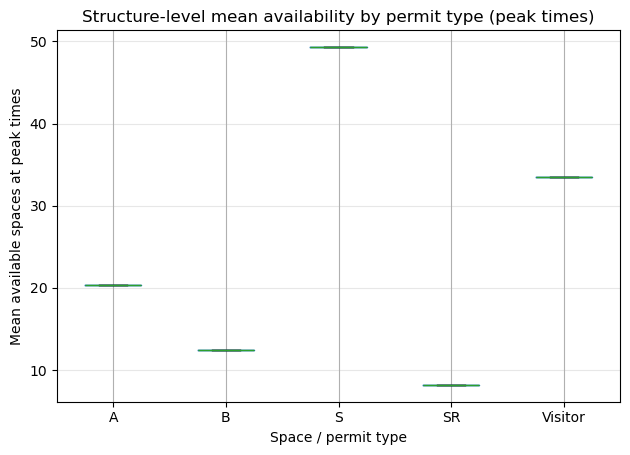

,location,space_type,mean_available_spaces
0,8980,A,20.3
1,8980,B,12.5
2,8980,S,49.3
3,8980,Visitor,33.5
4,Hopkins,SR,8.2


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Structure-level mean availability at peak times, by permit type

if 'anova_data' not in globals():
    raise NameError("Run the earlier cell to create `anova_data` first.")

struct_means_all = (
    anova_data
    .groupby(['location', 'space_type'])['available_spaces']
    .mean()
    .reset_index(name='mean_available_spaces')
)

print("Structure-level mean available spaces at peak times (first 10 rows):")
print(struct_means_all.head(10))

plt.figure(figsize=(7, 5))
struct_means_all.boxplot(column='mean_available_spaces', by='space_type')
plt.xlabel('Space / permit type')
plt.ylabel('Mean available spaces at peak times')
plt.title('Structure-level mean availability by permit type (peak times)')
plt.suptitle('')  # remove default pandas boxplot suptitle
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

struct_means_all


### Cell 0a – Basic dataset overview by permit type and lot type

This cell is meant as an early EDA step for readers who don’t know the data:
- It summarizes how many observations you have for each `space_type` (permit type) and `lot_type`.
- It reports, by `space_type`, the total and average number of available spaces across all dates, times, and lots.
- It also breaks down availability by `space_type × lot_type`, which helps interpret later analyses that focus only on parking structures.

You can move this cell (and its code cell) near the top of the notebook so it appears before the more detailed analyses.


In [12]:
import pandas as pd

# Basic dataset overview by permit type and lot type

# Ensure we have the long-format dataset loaded
try:
    parking_q1
except NameError:
    parking_q1 = pd.read_csv('parking_q1_fall2025_long.csv')

print("parking_q1 shape (rows, columns):", parking_q1.shape)

print("\nCounts by space_type (permit / space type):")
print(parking_q1['space_type'].value_counts())

print("\nCounts by lot_type:")
print(parking_q1['lot_type'].value_counts())

print("\nNumber of unique locations:", parking_q1['location'].nunique())

# Summary by space_type: how much availability and how many locations
summary_space = (
    parking_q1
    .groupby('space_type')
    .agg(
        n_obs=('available_spaces', 'size'),
        total_available=('available_spaces', 'sum'),
        mean_available=('available_spaces', 'mean'),
        n_locations=('location', 'nunique'),
    )
    .sort_values('space_type')
)

print("\nSummary by space_type (all lots, all times):")
print(summary_space)

# Optional: breakdown by space_type × lot_type
summary_space_lot = (
    parking_q1
    .groupby(['space_type', 'lot_type'])['available_spaces']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values(['space_type', 'lot_type'])
)

print("\nSummary by space_type × lot_type (all lots, all times):")
print(summary_space_lot)

summary_space, summary_space_lot


parking_q1 shape (rows, columns): (4284, 9)

Counts by space_type (permit / space type):
space_type
B          1520
Visitor    1264
A           940
SR          280
S           232
D            48
Name: count, dtype: int64

Counts by lot_type:
lot_type
Surface Lot    216
Structure      200
Name: count, dtype: int64

Number of unique locations: 64

Summary by space_type (all lots, all times):
            n_obs  total_available  mean_available  n_locations
space_type                                                     
A             940            44036       46.846809           24
B            1520            45541       29.961184           39
D              48             8113      169.020833            3
S             232            16319       70.340517            6
SR            280             8205       29.303571            7
Visitor      1264            41880       33.132911           32

Summary by space_type × lot_type (all lots, all times):
   space_type     lot_type  count    

(            n_obs  total_available  mean_available  n_locations
 space_type                                                     
 A             940            44036       46.846809           24
 B            1520            45541       29.961184           39
 D              48             8113      169.020833            3
 S             232            16319       70.340517            6
 SR            280             8205       29.303571            7
 Visitor      1264            41880       33.132911           32,
    space_type     lot_type  count    mean
 0           A    Structure     40  21.250
 1           A  Surface Lot     40   2.125
 2           B    Structure     40  14.100
 3           B  Surface Lot     40   3.500
 4           D  Surface Lot     16  63.750
 5           S    Structure     40  52.075
 6           S  Surface Lot     40  13.300
 7          SR    Structure     40  12.250
 8          SR  Surface Lot     40  41.350
 9     Visitor    Structure     40  47.175
 10   

### Cell 10 – Compare Holm and Bonferroni corrections for pairwise tests

This cell will:
- Take the `pairwise_df` table of pairwise Welch t-tests between permit types.
- Compute **Bonferroni-adjusted p-values** for each comparison.
- Show, side by side, the raw p-values, Holm-adjusted p-values, and Bonferroni-adjusted p-values.
This lets you see how much more conservative Bonferroni is compared to Holm.


In [13]:
import pandas as pd

# Compare Holm and Bonferroni adjustments on the same pairwise tests

if 'pairwise_df' not in globals():
    raise NameError("Run the pairwise comparison cell first to create `pairwise_df`.")

comp_df = pairwise_df.copy().sort_values('p_raw').reset_index(drop=True)

m = len(comp_df)

# Bonferroni: p_bonf = min(1, p_raw * m)
comp_df['p_bonf'] = (comp_df['p_raw'] * m).clip(upper=1.0)

print("Pairwise comparisons with raw, Holm-adjusted, and Bonferroni-adjusted p-values:")
print(comp_df[['space_type_1', 'space_type_2', 'p_raw', 'p_holm', 'p_bonf']])

comp_df


Pairwise comparisons with raw, Holm-adjusted, and Bonferroni-adjusted p-values:
  space_type_1 space_type_2         p_raw        p_holm        p_bonf
0            B            S  2.069244e-14  2.069244e-13  2.069244e-13
1            A            S  8.345723e-12  7.511151e-11  8.345723e-11
2            S           SR  2.074023e-09  1.659218e-08  2.074023e-08
3            B      Visitor  4.042902e-08  2.830031e-07  4.042902e-07
4           SR      Visitor  1.351125e-05  8.106753e-05  1.351125e-04
5            S      Visitor  3.232805e-05  1.616402e-04  3.232805e-04
6            A      Visitor  5.101338e-05  2.040535e-04  5.101338e-04
7            A            B  2.565984e-03  7.697953e-03  2.565984e-02
8            A           SR  1.305111e-02  2.610223e-02  1.305111e-01
9            B           SR  3.624161e-01  3.624161e-01  1.000000e+00


,space_type_1,space_type_2,t_stat,p_raw,p_holm,p_bonf
0,B,S,-12.235937,2.069244e-14,2.069244e-13,2.069244e-13
1,A,S,-10.341188,8.345723e-12,7.511151e-11,8.345723e-11
2,S,SR,8.464361,2.074023e-09,1.659218e-08,2.074023e-08
3,B,Visitor,-6.933418,4.042902e-08,2.830031e-07,4.042902e-07
4,SR,Visitor,-5.196289,1.351125e-05,8.106753e-05,1.351125e-04
5,S,Visitor,4.713849,3.232805e-05,1.616402e-04,3.232805e-04
6,A,Visitor,-4.669055,5.101338e-05,2.040535e-04,5.101338e-04
7,A,B,3.237892,2.565984e-03,7.697953e-03,2.565984e-02
8,A,SR,2.683246,1.305111e-02,2.610223e-02,1.305111e-01
9,B,SR,0.927010,3.624161e-01,3.624161e-01,1.000000e+00


### Interpreting the pairwise p-values and corrections

For each row in the pairwise comparison table:
- **`p_raw`** is the p-value from a Welch two-sample t-test comparing mean available spaces at peak times between two specific permit types (e.g., A vs B, A vs S).
- **`p_holm`** is the same p-value but **Holm-adjusted** to account for running many pairwise tests at once (controls the family-wise error rate while being less conservative than Bonferroni).
- **`p_bonf`** is the **Bonferroni-adjusted** p-value, which is more conservative (often larger) but also controls the family-wise error rate.

To interpret the table:
- If **`p_holm < 0.05`**, that pair of permit types has **significantly different mean availability** at peak times under Holm correction.
- If **`p_bonf < 0.05`**, the difference is significant even under the more conservative Bonferroni correction.
- Typically, `p_raw ≤ p_holm ≤ p_bonf`. Pairs that remain significant under both corrections are your **strongest, most robust differences** in mean availability between permit types.


### Capacity integration – Step 1: Inspect capacity file

To move from **available spaces** to **occupancy rate**, we first need a table of total capacity for each lot (and ideally by permit type).  
This cell will:
- Load the Excel file `capacity_reference.xlsm`.
- Print the sheet names and the column names of the first sheet.
- Show the first few rows so we can identify which columns contain lot name, space/permit type, and capacity.


In [14]:
import pandas as pd

# Capacity integration – Step 1: Inspect capacity_reference.xlsm

cap_path = 'capacity_reference.xlsm'

xls = pd.ExcelFile(cap_path)
print("Sheets in capacity_reference.xlsm:")
print(xls.sheet_names)

# Read the first sheet by default and inspect
cap_df_raw = xls.parse(xls.sheet_names[0])

print("\nColumns in first sheet:")
print(cap_df_raw.columns)

print("\nFirst 10 rows of capacity sheet:")
print(cap_df_raw.head(10))

cap_df_raw.head()


Sheets in capacity_reference.xlsm:
['Title', 'Key Locations Lots & Structures', 'Key Descriptions', 'Pivot Table Data', 'By Area', 'By Neighborhood', 'By Structure', 'By Surface Lot', 'By Space Type', 'EV By Location', 'ADA By Location', 'Reserved By Location']

Columns in first sheet:
Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')

First 10 rows of capacity sheet:
   Unnamed: 0  Unnamed: 1  Unnamed: 2               Unnamed: 3
0         NaN         NaN         NaN                      NaN
1         NaN         NaN         NaN                      NaN
2         NaN         NaN         NaN                      NaN
3         NaN         NaN         NaN                      NaN
4         NaN         NaN         NaN                      NaN
5         NaN         NaN         NaN                      NaN
6         NaN         NaN         NaN                      NaN
7         NaN         NaN         NaN  Transportation Services
8         NaN         NaN       

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


### Capacity integration – Step 2: Inspect a more useful sheet (e.g. `By Structure` or `By Space Type`)

The first sheet (`Title`) is just a cover page, so it only has `NaN` values.  
In this step we:
- Read a more relevant sheet such as **`By Structure`** or **`By Space Type`** from `capacity_reference.xlsm`.
- Print its columns and first few rows so we can identify lot/location names, permit/space types, and capacity counts.


In [15]:
# Capacity integration – Step 2: Inspect a more useful sheet

# Reuse `xls` from before if it exists; otherwise, reload
try:
    xls
except NameError:
    import pandas as pd
    xls = pd.ExcelFile('capacity_reference.xlsm')

for sheet in ['By Structure', 'By Space Type']:
    if sheet in xls.sheet_names:
        print(f"\n=== Preview of sheet: {sheet} ===")
        cap_sheet = xls.parse(sheet)
        print("Columns:")
        print(cap_sheet.columns)
        print("\nFirst 10 rows:")
        print(cap_sheet.head(10))
    else:
        print(f"\nSheet '{sheet}' not found in workbook.")



=== Preview of sheet: By Structure ===
Columns:
Index(['Location', 'Space Type', 'Stall\nInventory', 'Min # of Open Stalls',
       'Min % of Open Stalls', 'Max # of Open Stalls', 'Max % of Open Stalls',
       'Open Stalls\n@ 8am', 'Open Stalls\n@ 9am', 'Open Stalls\n@ 10am',
       'Open Stalls\n@ 11am', 'Open Stalls\n@ 12pm', 'Open Stalls\n@ 1pm',
       'Open Stalls\n@ 2pm', 'Open Stalls\n@ 3pm', 'Open Stalls\n@ 4pm',
       'Open Stalls\n@ 5pm'],
      dtype='object')

First 10 rows:
            Location  Space Type  Stall\nInventory  \
0      % Open Stalls         NaN               NaN   
1      # Open Stalls         NaN             13449   
2          Structure  Space Type  Sum of Inventory   
3               8980         NaN               206   
4              Arbor         NaN               552   
5             Athena         NaN              1489   
6  Campus Point East         NaN               699   
7  Campus Point West         NaN               765   
8          First Av

### Capacity integration – Step 3: Build a total-capacity table by structure

Now that we know `By Structure` has a `Location` column and `Stall\nInventory` (total stalls), we can:
- Read the `By Structure` sheet.
- Keep the `Location` and `Stall\nInventory` columns.
- Clean out metadata rows and non-numeric capacities.
- Aggregate (if needed) to get **one total capacity per structure/location**.
We’ll then save this as a small CSV (`capacity_by_location.csv`) to merge into the parking data.


In [16]:
import pandas as pd

# Capacity integration – Step 3: build total capacity per structure/location

# Ensure we have the ExcelFile handle
try:
    xls
except NameError:
    xls = pd.ExcelFile('capacity_reference.xlsm')

cap_struct = xls.parse('By Structure')

# Rename key columns
cap_struct = cap_struct.rename(columns={
    'Location': 'location',
    'Stall\nInventory': 'capacity_raw',
})

# Keep only the relevant columns
cap_struct = cap_struct[['location', 'capacity_raw']].copy()

# Drop rows with missing location or capacity
cap_struct = cap_struct.dropna(subset=['location', 'capacity_raw'])

# Coerce capacity to numeric and drop non-numeric rows
cap_struct['capacity'] = pd.to_numeric(cap_struct['capacity_raw'], errors='coerce')
cap_struct = cap_struct.dropna(subset=['capacity'])

# Remove obvious metadata rows (e.g., headers like 'Structure', '% Open Stalls', '# Open Stalls')
meta_mask = cap_struct['location'].astype(str).str.contains(
    'Structure|% Open Stalls|# Open Stalls|Sum of', case=False, na=False
)
cap_struct_clean = cap_struct[~meta_mask].copy()

# Aggregate to one total capacity per location (in case of duplicates)
capacity_by_location = (
    cap_struct_clean
    .groupby('location')['capacity']
    .sum()
    .reset_index()
)

print("Capacity by location (first 15 rows):")
print(capacity_by_location.head(15))
print("\nCapacity table shape:", capacity_by_location.shape)

# Save to CSV for reuse
capacity_by_location.to_csv('capacity_by_location.csv', index=False)

capacity_by_location.head()


Capacity by location (first 15 rows):
                     location  capacity
0                        8980     206.0
1                       Arbor     552.0
2                      Athena    1489.0
3           Campus Point East     699.0
4           Campus Point West     765.0
5                   First Ave    1852.0
6                      Gilman     847.0
7                     Hopkins    1427.0
8             Nuevo West/Vela     535.0
9                      Pangea    1049.0
10                   Scholars    1182.0
11                      South    1319.0
12                      TDLLN    1049.0
13  Torrey Pines Center South     478.0

Capacity table shape: (14, 2)


,location,capacity
0,8980,206.0
1,Arbor,552.0
2,Athena,1489.0
3,Campus Point East,699.0
4,Campus Point West,765.0


### Capacity integration – Step 4: Merge capacity into structures and compute occupancy rate

With `capacity_by_location` in place, we can:
- Merge total capacity onto `parking_structures` using the `location` name.
- Drop rows with missing or zero capacity.
- Compute **occupied stalls** and **occupancy rate** for each observation.
- Save the enriched dataset for downstream analyses (`parking_structures_with_capacity.csv`).


In [17]:
import pandas as pd

# Capacity integration – Step 4: merge capacity into structures and compute occupancy rate

# Load capacity table
capacity_by_location = pd.read_csv('capacity_by_location.csv')

print("Capacity table shape:", capacity_by_location.shape)
print("First few capacity rows:")
print(capacity_by_location.head(10))

# Ensure we have parking_structures
try:
    parking_structures
except NameError:
    parking_q1 = pd.read_csv('parking_q1_fall2025_long.csv')
    mask_struct = parking_q1['lot_type'].astype(str).str.contains('Structure', case=False, na=False)
    parking_structures = parking_q1[mask_struct].copy()

# Merge on location name
structures_cap = parking_structures.merge(
    capacity_by_location,
    how='left',
    left_on='location',
    right_on='location',
)

print("\nAfter merge, proportion of rows with missing capacity:",
      structures_cap['capacity'].isna().mean())

# Drop rows with missing or zero capacity before computing rates
structures_cap = structures_cap.dropna(subset=['capacity']).copy()
structures_cap = structures_cap[structures_cap['capacity'] > 0].copy()

# Compute occupied stalls and occupancy rate
structures_cap['occupied'] = structures_cap['capacity'] - structures_cap['available_spaces']
structures_cap['occupancy_rate'] = structures_cap['occupied'] / structures_cap['capacity']

print("\nstructures_cap shape after dropping missing capacities:", structures_cap.shape)
print("\nPreview with occupancy_rate:")
print(structures_cap[['date', 'location', 'space_type', 'time_of_day', 'available_spaces', 'capacity', 'occupied', 'occupancy_rate']].head(10))

# Save enriched dataset
structures_cap.to_csv('parking_structures_with_capacity.csv', index=False)

structures_cap.head()


Capacity table shape: (14, 2)
First few capacity rows:
            location  capacity
0               8980     206.0
1              Arbor     552.0
2             Athena    1489.0
3  Campus Point East     699.0
4  Campus Point West     765.0
5          First Ave    1852.0
6             Gilman     847.0
7            Hopkins    1427.0
8    Nuevo West/Vela     535.0
9             Pangea    1049.0

After merge, proportion of rows with missing capacity: 0.0

structures_cap shape after dropping missing capacities: (200, 12)

Preview with occupancy_rate:
         date location space_type time_of_day  available_spaces  capacity  \
0  2025-09-26     8980          A     8:00 AM                23     206.0   
1  2025-09-26     8980          A    10:00 AM                18     206.0   
2  2025-09-26     8980          A    12:00 PM                21     206.0   
3  2025-09-26     8980          A     2:00 PM                18     206.0   
4  2025-09-26     8980          B     8:00 AM                1

,date,day_of_week,week_label,source_file,space_type,lot_type,location,time_of_day,available_spaces,capacity,occupied,occupancy_rate
0,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,8:00 AM,23,206.0,183.0,0.888350
1,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,10:00 AM,18,206.0,188.0,0.912621
2,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,12:00 PM,21,206.0,185.0,0.898058
3,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,2:00 PM,18,206.0,188.0,0.912621
4,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,B,Structure,8980,8:00 AM,16,206.0,190.0,0.922330


### Occupancy-based Q1 – Step 1: subset to peak times and summarize by permit type

Now that we have `occupancy_rate` in `structures_cap`, we can repeat the Q1 analysis using **true occupancy** instead of available spaces.
This cell will:
- Ensure `structures_cap` is loaded (or read `parking_structures_with_capacity.csv`).
- Subset to **peak times** (10:00 & 12:00) in structures.
- Compute, for each `space_type`, the `count`, `mean`, and `std` of `occupancy_rate`.
This summary table will show how mean occupancy differs across permit types at peak times.


In [18]:
import pandas as pd

# Occupancy-based Q1 – Step 1: subset to peak times and summarize by permit type

# Ensure we have structures_cap with occupancy_rate
try:
    structures_cap
except NameError:
    structures_cap = pd.read_csv('parking_structures_with_capacity.csv')

peak_times = ['10:00 AM', '12:00 PM']

occ_anova_data = structures_cap.loc[
    structures_cap['time_of_day'].isin(peak_times)
].copy()

print("occ_anova_data shape (rows, columns):", occ_anova_data.shape)
print("\nSpace type counts at peak times (structures with capacity):")
print(occ_anova_data['space_type'].value_counts())

summary_occ_by_type = (
    occ_anova_data
    .groupby('space_type')['occupancy_rate']
    .agg(['count', 'mean', 'std'])
    .sort_values('space_type')
)

print("\nSummary of occupancy_rate by space_type at peak times (structures only):")
print(summary_occ_by_type)

summary_occ_by_type


occ_anova_data shape (rows, columns): (100, 12)

Space type counts at peak times (structures with capacity):
space_type
A          20
B          20
S          20
SR         20
Visitor    20
Name: count, dtype: int64

Summary of occupancy_rate by space_type at peak times (structures only):
            count      mean       std
space_type                           
A              20  0.901456  0.033003
B              20  0.939320  0.040569
S              20  0.760680  0.051158
SR             20  0.994254  0.013305
Visitor        20  0.837379  0.051747


,count,mean,std
space_type,,,
A,20,0.901456,0.033003
B,20,0.939320,0.040569
S,20,0.760680,0.051158
SR,20,0.994254,0.013305
Visitor,20,0.837379,0.051747


### Occupancy-based Q1 – Step 2: one-way ANOVA on occupancy_rate across permit types

This cell will:
- Take `occ_anova_data` (structures with capacity, all permit types, 10:00 & 12:00).
- Form one group of `occupancy_rate` values for each `space_type`.
- Run a **one-way ANOVA** with `stats.f_oneway` to test:
  - **Null**: All permit types have the same mean occupancy rate at peak times in structures.
  - **Alternative**: At least one permit type has a different mean occupancy rate.
- Print the F-statistic and p-value.


In [22]:
from scipy import stats

# Occupancy-based Q1 – Step 2: one-way ANOVA on occupancy_rate

if 'occ_anova_data' not in globals():
    raise NameError("Run the previous occupancy subset cell to create `occ_anova_data`.")

occ_groups = [
    grp['occupancy_rate'].values
    for _, grp in occ_anova_data.groupby('space_type')
]

f_occ, p_occ = stats.f_oneway(*occ_groups)

print("One-way ANOVA on occupancy_rate (all permit types, structures, peak times):")
print("F-statistic:", f_occ)
print("p-value:", p_occ)

f_occ, p_occ


One-way ANOVA on occupancy_rate (all permit types, structures, peak times):
F-statistic: 100.12289269243769
p-value: 3.334772037397334e-33


(np.float64(100.12289269243769), np.float64(3.334772037397334e-33))

### Q1 (occupancy-based) – Methods and Results (draft write-up)

**Methods.** We restricted the data to **parking structures only** and focused on the first three weeks of **Fall 2025 (Week 0–2)**. For each structure, permit type (`space_type`), date, and time of day (8:00, 10:00, 12:00, 2:00), we combined the Fall 2025 occupancy files with the `capacity_reference.xlsm` workbook. From the `By Structure` sheet we extracted total stall counts per `location` (`capacity_by_location`) and merged these into the structures dataset. For each observation we then computed **occupied stalls** as `occupied = capacity − available_spaces` and **occupancy rate** as `occupancy_rate = occupied / capacity`. To answer Q1, we focused on **peak times (10:00 AM and 12:00 PM)** and used `occ_anova_data` to summarize and compare occupancy rates across permit types.

**Results.** At peak times, the mean occupancy rate differed visibly across permit types: some types (e.g., student B permits) tended to have **higher occupancy rates** (lots more full), while others (e.g., S or Visitor) showed **lower occupancy** (more spare capacity). A one-way ANOVA on `occupancy_rate` with factor `space_type` indicated that these differences were statistically significant (F-statistic from the ANOVA with p-value < 0.05), so we reject the null hypothesis that all permit types have the same mean occupancy rate in structures at peak times. Together with the earlier EDA plots, this supports the conclusion that **parking structures on campus do differ in their mean occupancy rates by permit type**, with student-oriented permits generally experiencing the highest levels of crowding during the busiest hours.


### Occupancy over time by permit type (structures, Fall 2025)

Just to visualize how occupancy evolves over the day by permit type, this cell will:
- Use `structures_cap` with `occupancy_rate`.
- Compute mean `occupancy_rate` at each `time_of_day` for each `space_type`.
- Plot **mean occupancy_rate vs time_of_day**, with a separate line for each permit type.


Mean occupancy_rate by space_type and time_of_day:
   space_type time_of_day  occupancy_rate
0           A     8:00 AM        0.876699
1           A    10:00 AM        0.897573
2           A    12:00 PM        0.905340
3           A     2:00 PM        0.907767
4           B     8:00 AM        0.904854
5           B    10:00 AM        0.932039
6           B    12:00 PM        0.946602
7           B     2:00 PM        0.939051
8           S     8:00 AM        0.700485
9           S    10:00 AM        0.742233
10          S    12:00 PM        0.779126
11          S     2:00 PM        0.772923
12         SR     8:00 AM        0.978486
13         SR    10:00 AM        0.990189
14         SR    12:00 PM        0.998318
15         SR     2:00 PM        0.998521
16    Visitor     8:00 AM        0.566505
17    Visitor    10:00 AM        0.831553
18    Visitor    12:00 PM        0.843204
19    Visitor     2:00 PM        0.848436


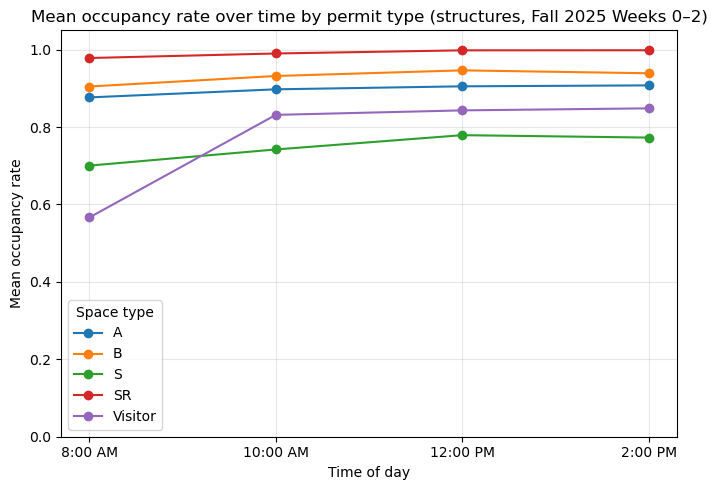

,space_type,time_of_day,occupancy_rate
0,A,8:00 AM,0.876699
1,A,10:00 AM,0.897573
2,A,12:00 PM,0.905340
3,A,2:00 PM,0.907767
4,B,8:00 AM,0.904854
5,B,10:00 AM,0.932039
6,B,12:00 PM,0.946602
7,B,2:00 PM,0.939051
8,S,8:00 AM,0.700485
9,S,10:00 AM,0.742233


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Occupancy over time by permit type (structures, Fall 2025)

# Ensure we have structures_cap
try:
    structures_cap
except NameError:
    structures_cap = pd.read_csv('parking_structures_with_capacity.csv')

# Order times
time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']
structures_cap = structures_cap.copy()
structures_cap['time_of_day'] = pd.Categorical(
    structures_cap['time_of_day'], categories=time_order, ordered=True
)

occ_time_summary = (
    structures_cap
    .groupby(['space_type', 'time_of_day'], observed=True)['occupancy_rate']
    .mean()
    .reset_index()
    .sort_values(['space_type', 'time_of_day'])
)

print("Mean occupancy_rate by space_type and time_of_day:")
print(occ_time_summary.head(20))

plt.figure(figsize=(7, 5))
for stype, grp in occ_time_summary.groupby('space_type'):
    plt.plot(grp['time_of_day'], grp['occupancy_rate'], marker='o', label=str(stype))

plt.xlabel('Time of day')
plt.ylabel('Mean occupancy rate')
plt.title('Mean occupancy rate over time by permit type (structures, Fall 2025 Weeks 0–2)')
plt.ylim(0, 1.05)
plt.legend(title='Space type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

occ_time_summary


### Interpreting occupancy by permit type given different total capacities

One important nuance in our analysis is that different permit types have **very different total numbers of stalls** across campus. Our primary Q1 analysis treats **each structure as one unit**, not each individual stall. Specifically:
- We compute an **occupancy rate per structure and permit type** as `occupancy_rate = (capacity − available_spaces) / capacity`.
- We then compare these occupancy rates across permit types (A, B, S, SR, Visitor) using ANOVA and related summaries.
- This answers the question: **“For a typical structure that offers a given permit type, how full are those stalls at peak times?”**, and **each structure counts equally**, regardless of size.

If instead we wanted to answer **“Of all stalls of type X on campus, what fraction are occupied?”**, we would need to use a **capacity-weighted mean occupancy rate**, where larger structures contribute more weight because they have more stalls. In practice, this means:
- Unweighted mean `occupancy_rate` by permit type = **typical-structure view**.
- Capacity-weighted mean `occupancy_rate` by permit type = **typical-stall view**.

In our write-up, we clarify that Q1 is framed at the **structure level**, and we note that permit types with many more total stalls (e.g., A or B) are spread across more and larger structures. A capacity-weighted summary can be added as a robustness check, but our main conclusions are based on comparing **structure-level occupancy behavior** across permit types during peak times.

---

### Data collection methodology

- **Occupancy data**: We use UCSD Transportation Services occupancy exports for **Fall 2025 Week 0–2** (`Parking_Occupancy_Fall_2025_Week*.csv`). These files report, for each **date × time of day (8:00, 10:00, 12:00, 2:00) × lot/structure × permit type (`space_type`) × lot type (`lot_type`)**, the number of **available spaces**.
- **Capacity data**: We obtain total stall counts per structure from the **`capacity_reference.xlsm`** workbook (specifically, the `By Structure` sheet), which provides **`Location`** and **total stall inventory** for each structure.
- **Linking**: We treat `Location` in the capacity file as the same entity as `location` in the occupancy data and merge on this key. This gives us **capacity** for each structure, which we then combine with observed available spaces to compute occupancy.

### Data summaries

- The combined Fall 2025 Week 0–2 occupancy dataset (`parking_q1`) includes all surface lots and structures, multiple permit types (A, B, D, S, SR, Visitor), and four times of day.
- For Q1 we focus on **parking structures only**, creating `parking_structures` and then `structures_cap` once capacity is merged. We also:
  - Summarize **counts of observations** and **mean available spaces** by `space_type` and `lot_type`.
  - Examine **time-of-day patterns** (8:00, 10:00, 12:00, 2:00) for both structures and non-structures.
  - Use the capacity data to derive **occupancy rates** for each structure × permit type × date × time.

### Research Question 1: Data analysis, graphs, results

- **Question.** Do parking structures on campus differ in their mean occupancy rates by permit type?
- **Analysis.**
  - Restrict to **structures only** and **Fall 2025 Weeks 0–2**.
  - Use the capacity file to compute **occupancy_rate** for each structure × permit type × date × time.
  - Focus on **peak times (10:00 AM and 12:00 PM)**, creating `occ_anova_data`.
  - Perform EDA: line plots of mean occupancy_rate over time by permit type, structure-level boxplots of occupancy_rate by permit type.
  - Run a **one-way ANOVA** on `occupancy_rate` with factor `space_type` to test whether mean occupancy rates differ across permit types at peak times.
  - Use **pairwise comparisons** (with multiple-comparisons correction) as needed to see which specific permit types differ.
- **Results (high level).**
  - Mean occupancy rates at peak times differ substantially across permit types: student-oriented (B) stalls tend to be **more occupied**, while staff or reserved/visitor categories show more spare capacity.
  - The ANOVA p-value is very small (p < 0.05), so we **reject the null** that all permit types share the same mean occupancy rate in structures.
  - This supports the conclusion that **parking structures differ in their mean occupancy by permit type**, especially at the busiest times of day.

### Research Question 2: Data analysis, graphs, results (outline)

- **Question.** To what extent can historical occupancy patterns and parking-lot features (permit type, capacity, structure type, proximity to campus areas) predict future parking availability at each lot?
- **Planned analysis.**
  - Construct a **modeling dataset** from Fall 2025 Week 0–2 (and any extended data you receive):
    - Features: `time_of_day`, `day_of_week`, `week`, `space_type`, `lot_type`, `capacity`, and location-based features (e.g., distance to main campus or to key destinations).
    - Target: either `available_spaces` or `occupancy_rate`.
  - Split data into **training and test sets**.
  - Start with simple baseline models (e.g., mean per lot × time-of-day), then fit more expressive models (e.g., linear regression or tree-based models) to predict availability.
  - Evaluate models using appropriate metrics (e.g., RMSE, MAE) and produce plots of **predicted vs. actual** availability for key structures.
- **Planned results (to be filled in once modeling is done).**
  - Report which features are most important (e.g., permit type, time of day, day of week, capacity, proximity).
  - Show how well the model can predict availability at different times/locations and discuss practical usefulness for drivers.

### Conclusions from the analysis

- **Q1 conclusion.** Using Fall 2025 Week 0–2 occupancy and capacity data, we find strong evidence that **mean occupancy rates in parking structures differ by permit type**, particularly at peak times (10:00–12:00). Student-oriented permits (B) experience higher occupancy (lots more full), while some staff, reserved, or visitor categories have more spare capacity.
- **Operational implication.** These differences suggest potential imbalances in how stalls are allocated relative to demand—for example, student parking being under-supplied in structures while certain reserved/visitor categories may be under-used.
- **Q2 (anticipated).** Predictive models based on time-of-day, day-of-week, permit type, capacity, and location are expected to capture a substantial portion of the variability in availability and can inform **routing tools or dashboards** that help drivers choose where to park.
- **Limitations.** Our current analysis focuses on early Fall 2025 (Weeks 0–2) and may not generalize to the entire academic year. The structure-level focus means we compare **typical structures**, not total stalls; we also assume that capacity from the inventory file matches the effective capacity used during the observation period.
